In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import seaborn as sns

pd.options.display.max_columns = None
plt.style.use("fivethirtyeight")
plt.rcParams["figure.dpi"] = 150

In [2]:
X_train, X_ivs, y_train, col_names = pickle.load(open("../data/drd2_data.pickle", "rb"))

In [3]:
X_train = pd.DataFrame(X_train, columns=col_names)

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import make_scorer

D_cols = [col for col in col_names if "D" in col]

ct = ColumnTransformer(
    [("scaler", MinMaxScaler(), D_cols)],
    remainder="passthrough",
    verbose_feature_names_out=True,
)

pipe = Pipeline(
    [
        ("ct", ct),
        ("svr", SVR()),
    ]
)

metrics = {
    "rmse": make_scorer(mean_squared_error, squared=False),
    "evs": make_scorer(explained_variance_score),
}

# Define the hyperparameters
param_grid = {
    'svr__C': [1, 10, 100],  
    'svr__epsilon': [0.1, 0.2, 0.3],  
    'svr__kernel': ['linear', 'rbf'],  
    'svr__gamma': [1e-3, 1e-4, 1e-5, 1e-6]  
}

cv_more = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring=metrics,
    refit="rmse",
    verbose=3,
    return_train_score=True,
    n_jobs=-1,
)

results_more = cv_more.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 2/5] END svr__C=1, svr__epsilon=0.1, svr__gamma=0.001, svr__kernel=linear; evs: (train=0.770, test=0.392) rmse: (train=0.132, test=0.217) total time= 7.9min
[CV 1/5] END svr__C=1, svr__epsilon=0.1, svr__gamma=0.001, svr__kernel=linear; evs: (train=0.773, test=0.350) rmse: (train=0.133, test=0.217) total time= 8.2min
[CV 3/5] END svr__C=1, svr__epsilon=0.1, svr__gamma=0.001, svr__kernel=linear; evs: (train=0.765, test=0.437) rmse: (train=0.134, test=0.211) total time= 8.7min
[CV 4/5] END svr__C=1, svr__epsilon=0.1, svr__gamma=0.001, svr__kernel=linear; evs: (train=0.771, test=0.426) rmse: (train=0.132, test=0.210) total time= 9.0min
[CV 1/5] END svr__C=1, svr__epsilon=0.1, svr__gamma=0.001, svr__kernel=rbf; evs: (train=0.688, test=0.589) rmse: (train=0.155, test=0.173) total time=  35.8s
[CV 2/5] END svr__C=1, svr__epsilon=0.1, svr__gamma=0.001, svr__kernel=rbf; evs: (train=0.686, test=0.582) rmse: (train=0.155, test=0.18

In [71]:
pd.DataFrame(results_more.cv_results_).to_csv("../data/svr_grid.csv")

In [73]:
svr_grid.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_svr__C', 'param_svr__epsilon', 'param_svr__gamma',
       'param_svr__kernel', 'params', 'split0_test_rmse', 'split1_test_rmse',
       'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse',
       'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse',
       'split0_train_rmse', 'split1_train_rmse', 'split2_train_rmse',
       'split3_train_rmse', 'split4_train_rmse', 'mean_train_rmse',
       'std_train_rmse', 'split0_test_evs', 'split1_test_evs',
       'split2_test_evs', 'split3_test_evs', 'split4_test_evs',
       'mean_test_evs', 'std_test_evs', 'rank_test_evs', 'split0_train_evs',
       'split1_train_evs', 'split2_train_evs', 'split3_train_evs',
       'split4_train_evs', 'mean_train_evs', 'std_train_evs'],
      dtype='object')

In [74]:
svr_grid = pd.DataFrame(results_more.cv_results_).round(3)
svr_results = svr_grid[["param_svr__C", "param_svr__epsilon", "param_svr__gamma", "mean_test_rmse", "mean_test_evs"]]

In [ ]:
import numpy as np

# Replace inf and -inf with NaN
svr_results.replace([np.inf, -np.inf], np.nan, inplace=True)

sns.boxplot(x="param_svr__C", y="mean_test_rmse", data=svr_results)
sns.stripplot(x="param_svr__C", y="mean_test_rmse", data=svr_results, size=8, jitter=True, color="black", linewidth=1)

/opt/conda/envs/env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='param_svr__C', ylabel='mean_test_rmse'>

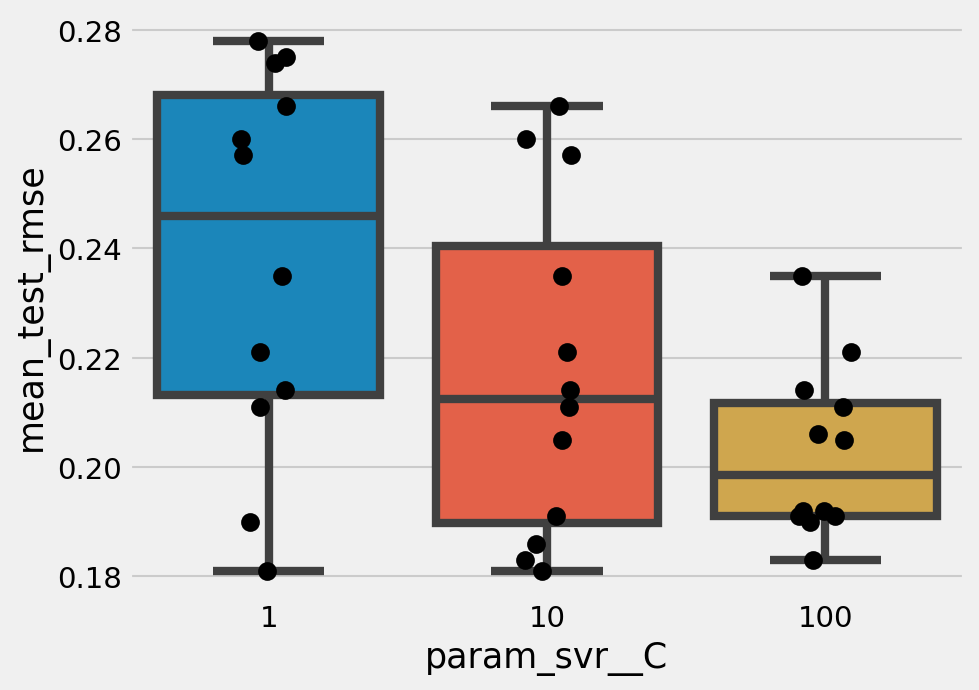

In [76]:
sns.boxplot(x="param_svr__C", y="mean_test_rmse", data=svr_results)
sns.stripplot(x="param_svr__C", y="mean_test_rmse", data=svr_results, size=8, jitter=True, color="black", linewidth=1)

<Axes: xlabel='param_svr__epsilon', ylabel='mean_test_evs'>

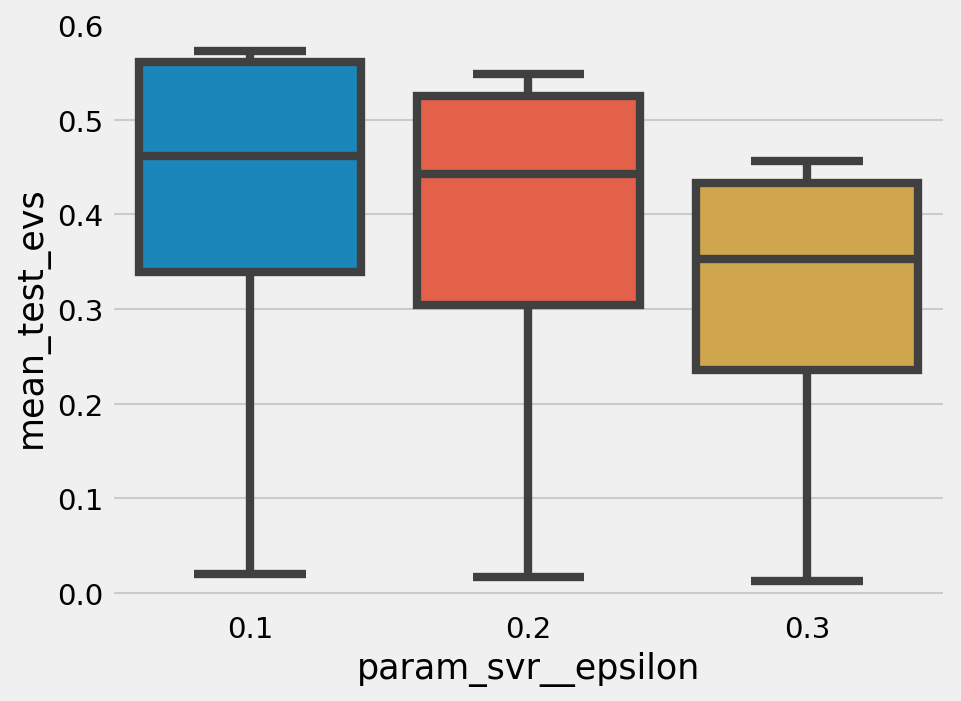

In [79]:
sns.boxplot(x="param_svr__epsilon", y="mean_test_evs", data=svr_results)

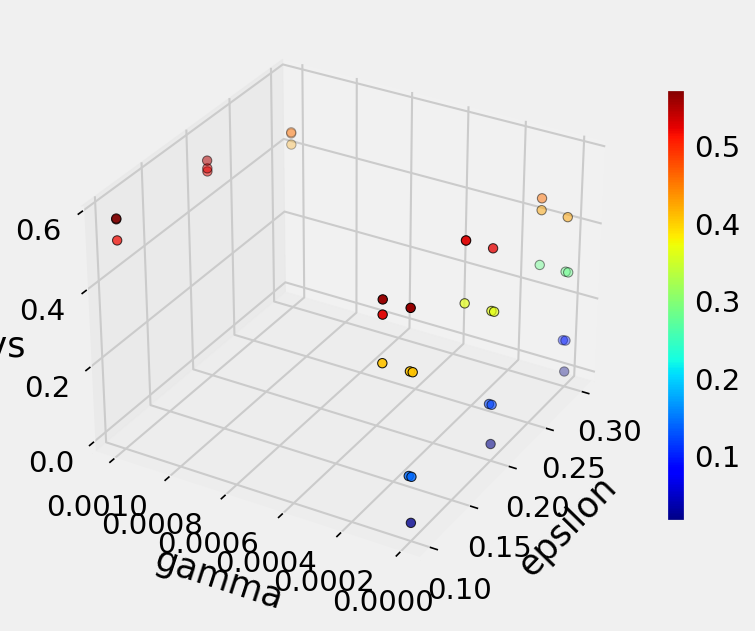

In [80]:
# 3d plot of optimal parameters

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    svr_grid["param_svr__epsilon"],
    svr_grid["param_svr__gamma"],
    svr_grid["mean_test_evs"],
    c=svr_grid["mean_test_evs"],
    cmap="jet",
    edgecolor="k",
)

cbar = plt.colorbar(ax.collections[0], fraction=0.026, pad=0.04)
cbar.set_label('Colorbar Label', rotation=270, labelpad=20)

ax.view_init(30, 210)

# Set labels
ax.set_xlabel("epsilon", fontsize=10, labelpad=10)
ax.set_ylabel("gamma", fontsize=10, labelpad=10)
ax.set_zlabel("evs", fontsize=10, labelpad=10)

# Set grid
ax.grid(True, linestyle='-', color='0.75')

plt.show()

In [81]:
cv_more.best_params_

{'svr__C': 1, 'svr__epsilon': 0.3, 'svr__gamma': 1e-06, 'svr__kernel': 'rbf'}

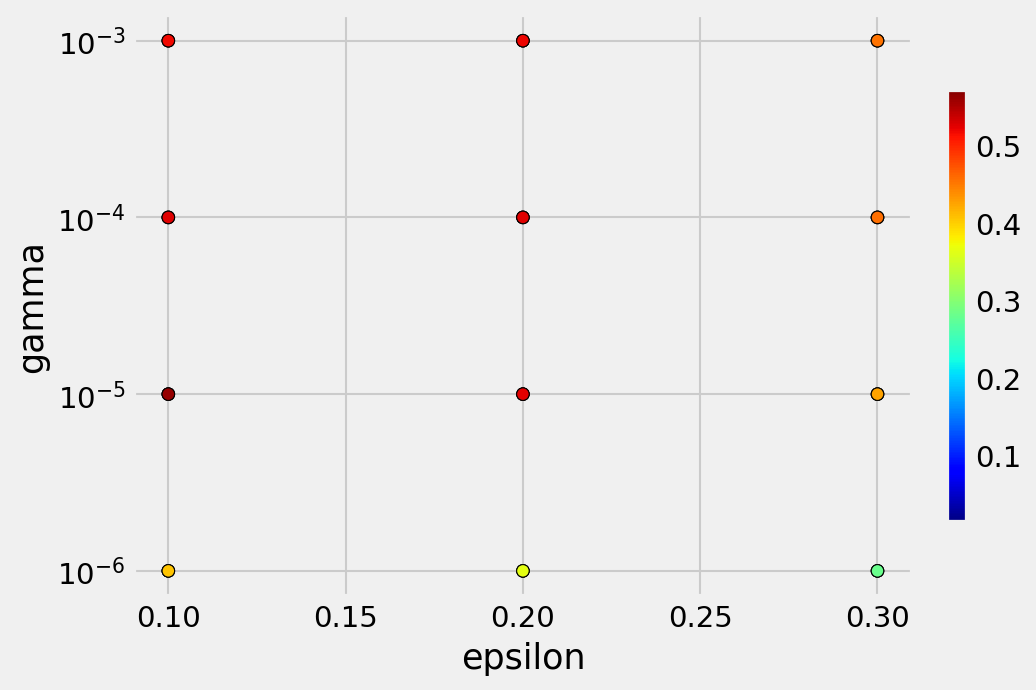

In [82]:
sc = plt.scatter(svr_results["param_svr__epsilon"], svr_results["param_svr__gamma"], c=svr_results["mean_test_evs"], cmap="jet", edgecolor="k")
plt.yscale("log")
plt.xlabel("epsilon")
plt.ylabel("gamma")

cbar = plt.colorbar(sc, fraction=0.026, pad=0.04)

In [85]:
svr_results.sort_values("mean_test_evs", ascending=False)

,param_svr__C,param_svr__epsilon,param_svr__gamma,mean_test_rmse,mean_test_evs
12,10,0.1,0.001,0.181,0.573
0,1,0.1,0.001,0.181,0.571
13,10,0.1,0.0001,0.183,0.562
26,100,0.1,0.00001,0.183,0.561
16,10,0.2,0.001,0.186,0.548
4,1,0.2,0.001,0.190,0.528
25,100,0.1,0.0001,0.190,0.525
17,10,0.2,0.0001,0.191,0.525
29,100,0.2,0.0001,0.191,0.525
30,100,0.2,0.00001,0.191,0.524


In [86]:
SVR().get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}